In [251]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager, rc
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import aic, bic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [257]:
cow_df = pd.read_csv("한우 등급별 월별도매가격 - 복사본.csv")

In [259]:
cow_df

,년-월,1++,1+,1,2
0,08-Jan,22901.14757,20577.05859,19004.17757,17435.07147
1,08-Feb,23208.93558,20908.60087,18812.60107,16692.78309
2,08-Mar,22159.84599,19619.94659,17619.07719,15669.12998
3,08-Apr,22091.84556,19619.08056,17322.94163,14571.03332
4,08-May,21445.54698,18658.58140,16368.98199,13765.77239
...,...,...,...,...,...
187,23-Aug,19293.72996,16293.19558,14563.59102,11066.08479
188,23-Sep,20191.40452,17733.27426,16176.34027,12554.71865
189,23-Oct,18873.48813,16240.84047,14996.02719,11778.05244
190,23-Nov,18333.33333,15741.92403,14408.05822,12230.20944


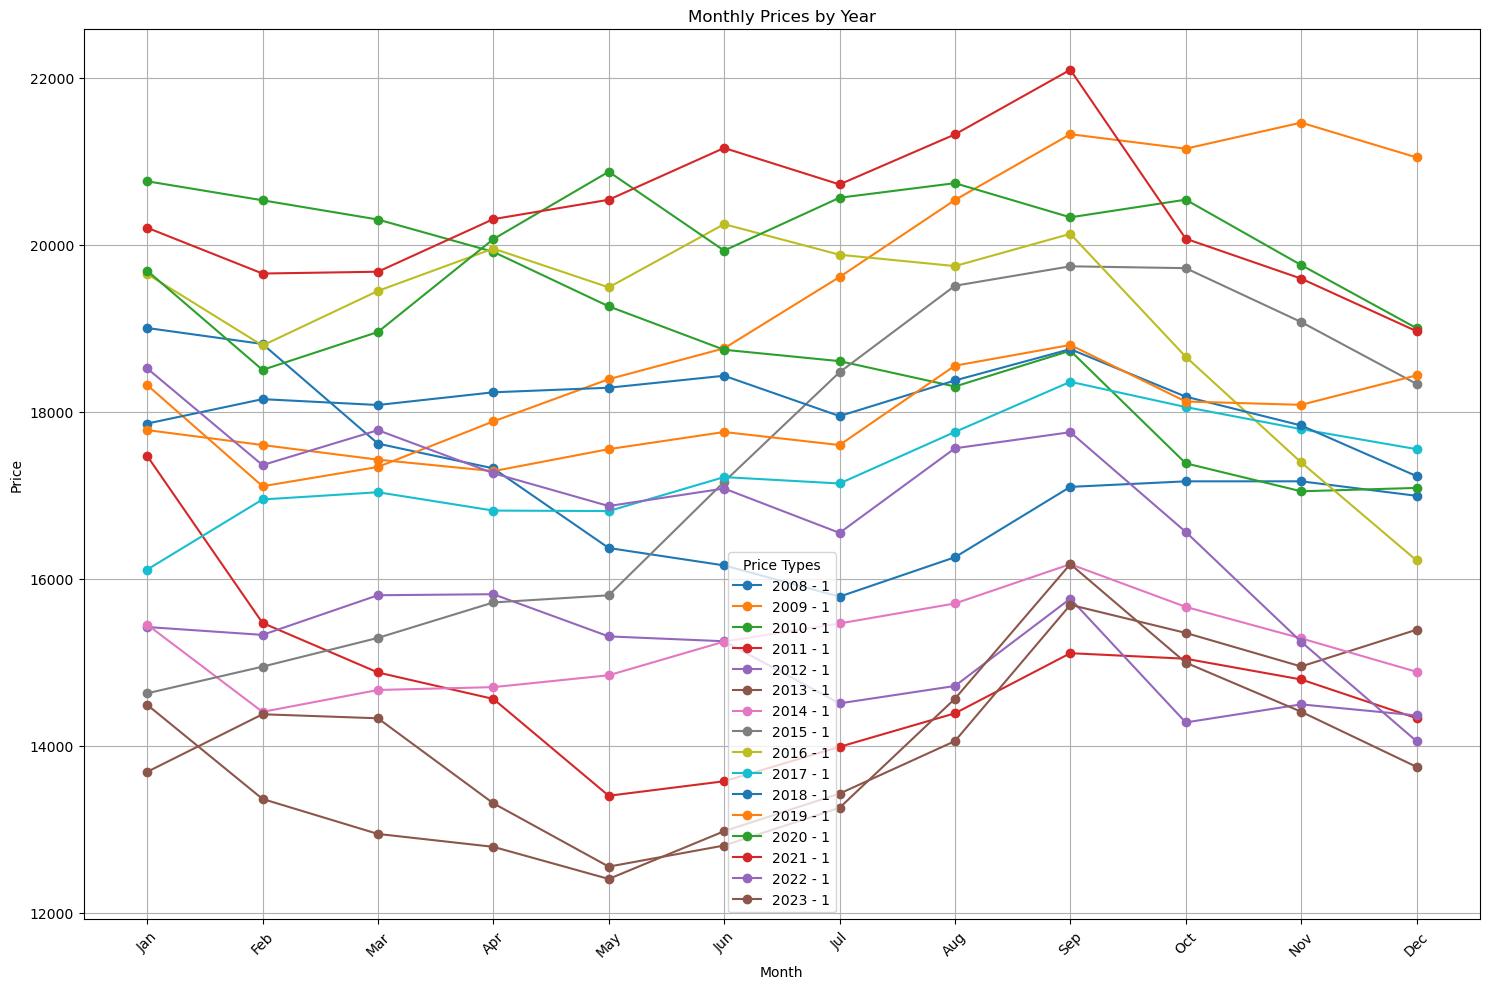

In [261]:
# 'Month-Year' 열을 datetime으로 변환
cow_df['Date'] = pd.to_datetime(cow_df['년-월'] , format='%y-%b')

# X축을 월로 설정하기 위해 월 숫자 추출
cow_df['Month'] = cow_df['Date'].dt.month
cow_df['Month_Name'] = cow_df['Date'].dt.strftime('%b')
cow_df['year'] = cow_df['Date'].dt.year

# 연도별 데이터 나누기
years = cow_df['Date'].dt.year.unique()

# 월 이름 리스트
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 연도별 그래프 그리기
plt.figure(figsize=(15, 10))
# 색상 목록
colors = plt.get_cmap('tab10').colors  # 탭10 색상 팔레트

for year in years:
    yearly_data = cow_df[cow_df['Date'].dt.year == year]
    plt.plot(yearly_data['Month_Name'], yearly_data['1'], label=f'{year} - 1', marker='o')


plt.title('Monthly Prices by Year')
plt.xlabel('Month')
plt.ylabel('Price')
plt.xticks(ticks=months, labels=months, rotation=45)
plt.legend(title='Price Types')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# 1,9월 추석명절에 한우 가격 상승 이거는 seasonal index로 확인해보자.
# 나중에 더미 변수 처리 하자.

C:\Users\임재성\AppData\Local\Temp\ipykernel_972\3836148351.py:14: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\임재성\AppData\Local\Temp\ipykernel_972\3836148351.py:14: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\임재성\AppData\Local\Temp\ipykernel_972\3836148351.py:14: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\임재성\AppData\Local\Temp\ipykernel_972\3836148351.py:14: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\임재성\AppData\Local\Temp\ipykernel_972\3836148351.py:14: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
C:\Users\임재성\AppData\Local\Temp\ipykernel_972\3836148351.py:14: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from cu

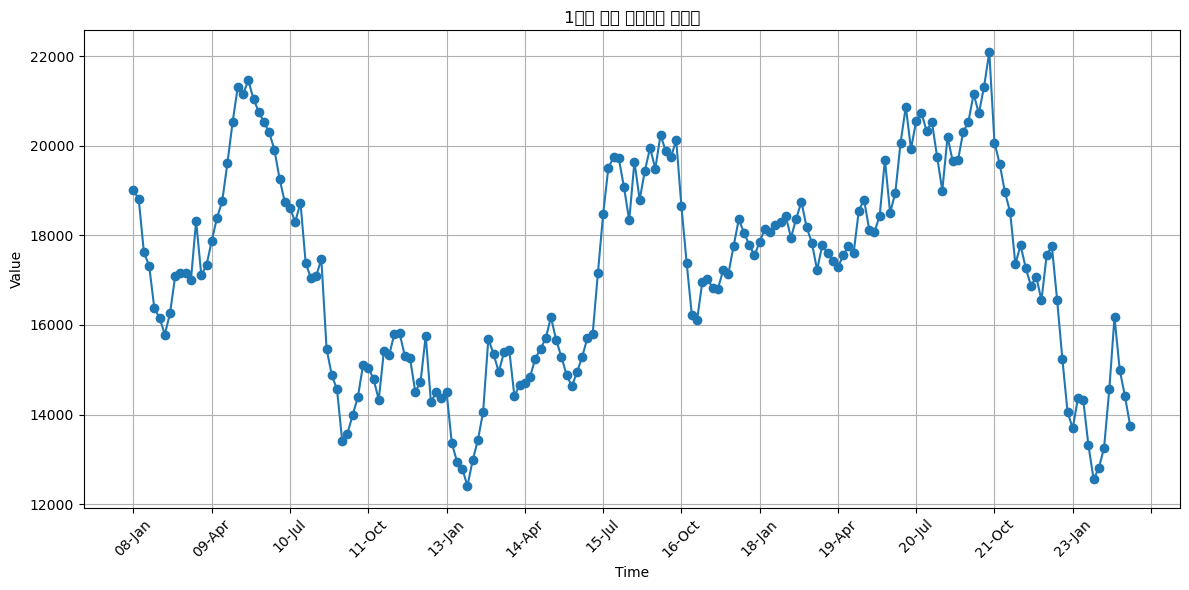

In [263]:
plt.figure(figsize=(12, 6))
plt.plot(cow_df['년-월'], cow_df['1'], marker='o', linestyle='-')

plt.title('1등급 한우 도매가격 시각화')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)

# x축 레이블 수 조정
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))  # 최대 6개의 레이블만 표시

plt.xticks(rotation=45)  # X축 레이블을 기울여서 읽기 쉽게 만들기
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [48]:
# ADF 검정
result = adfuller(cow_df['1'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# 결과 해석
if result[1] < 0.05:
    print('데이터가 정상성입니다.')
else:
    print('데이터가 비정상성입니다.')

ADF Statistic: -2.1014164144833165
p-value: 0.24394543569002874
Critical Values: {'1%': -3.4680615871598537, '5%': -2.8781061899535128, '10%': -2.5756015922004134}
데이터가 비정상성입니다.


In [50]:
# KPSS 검정
result = kpss(cow_df['1'], regression='c')
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[3])

# 결과 해석
if result[1] < 0.05:
    print('데이터가 비정상성입니다.')
else:
    print('데이터가 정상성입니다.')

KPSS Statistic: 0.20074713973531025
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
데이터가 정상성입니다.


C:\Users\임재성\AppData\Local\Temp\ipykernel_972\2187039392.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(cow_df['1'], regression='c')


In [52]:
# 여기서 1등급 한우 도매가격이 정상성인지 비정상성인지를 확인해야함. 

<Figure size 1200x600 with 0 Axes>

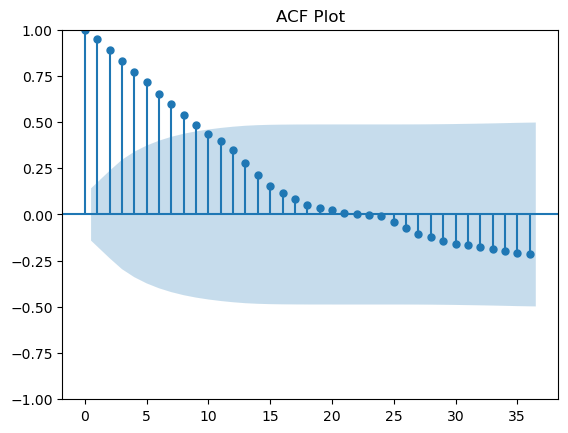

In [52]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(cow_df['1'], lags=36)
plt.title('ACF Plot')
plt.show()

In [58]:
# 일정한 주기성이 있고, 초기에 높은 자기 상관을 가진다고 해석할 수 있다. 

<Figure size 1200x600 with 0 Axes>

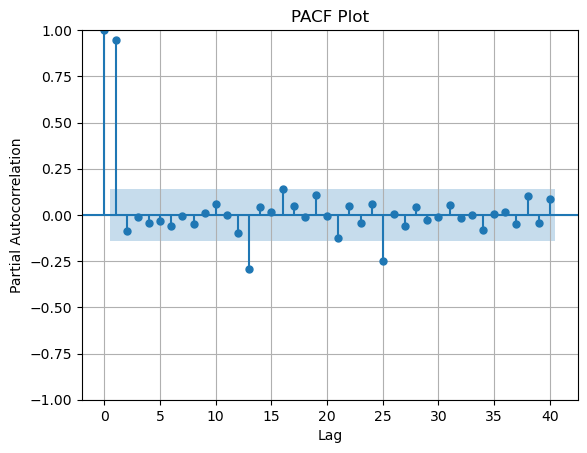

In [54]:
# PACF 플롯
plt.figure(figsize=(12, 6))
plot_pacf(cow_df['1'], lags=40)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [60]:
#첫 두 스파이크 이후 낮은 pacf값을 확인하였다. 일정한 주기로 갑자기 자기 상관이 높아진다고 할 수있다. 

C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


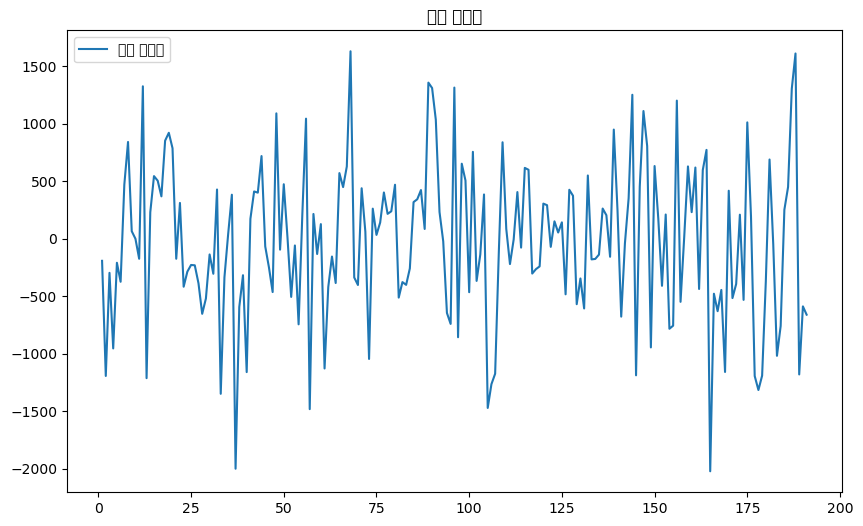

ADF Statistic: -3.971630933456861
ADF p-value: 0.0015665662585834966
KPSS Statistic: 0.08212280739176253
KPSS p-value: 0.1


C:\Users\임재성\AppData\Local\Temp\ipykernel_972\1495876674.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(differenced, regression='c')


In [265]:
# 1차 차분
differenced = cow_df['1'].diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(differenced, label='차분 데이터')
plt.title('차분 데이터')
plt.legend()
plt.show()

# 정상성 검정
result_adf = adfuller(differenced)
result_kpss = kpss(differenced, regression='c')

print("ADF Statistic:", result_adf[0])
print("ADF p-value:", result_adf[1])
print("KPSS Statistic:", result_kpss[0])
print("KPSS p-value:", result_kpss[1])

<Figure size 1200x600 with 0 Axes>

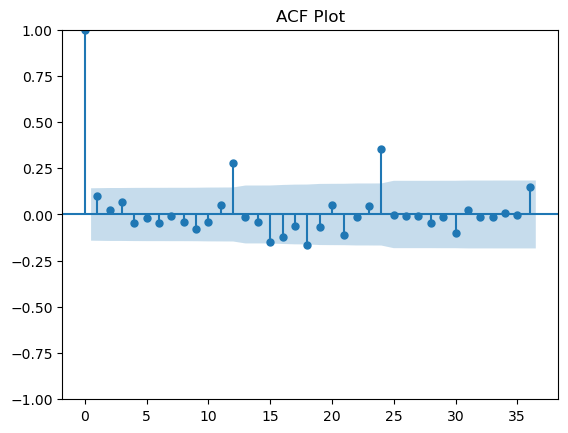

In [140]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(differenced, lags=36)
plt.title('ACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

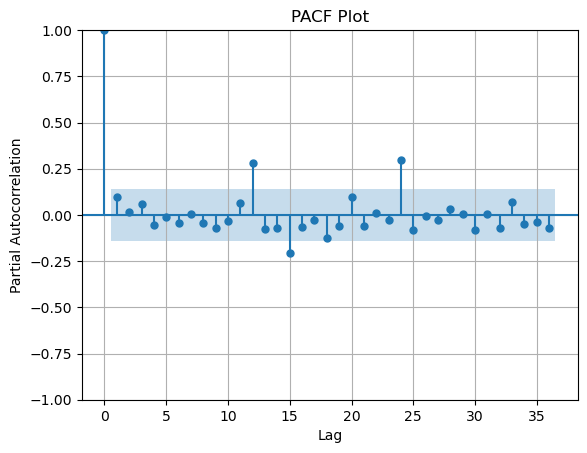

In [142]:
# PACF 플롯
plt.figure(figsize=(12, 6))
plot_pacf(differenced, lags=36)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


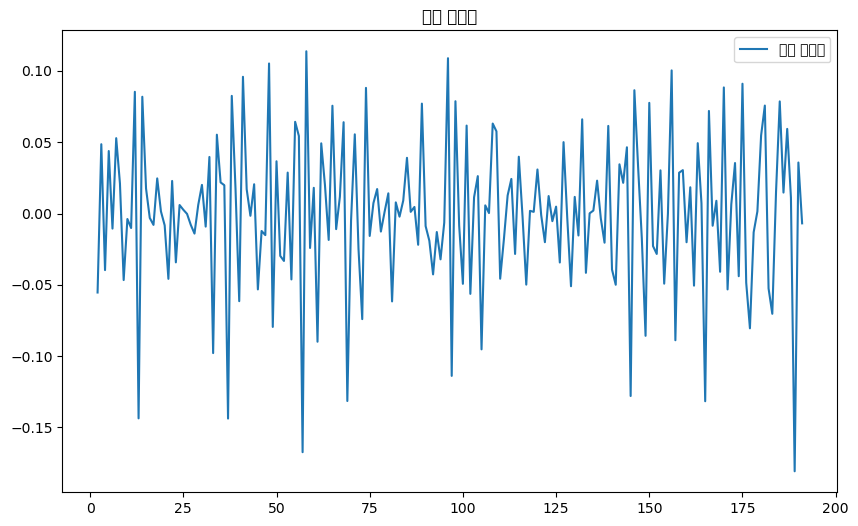

ADF Statistic: -9.748720904238354
ADF p-value: 8.123452415237645e-17
KPSS Statistic: 0.07878935315072759
KPSS p-value: 0.1


C:\Users\임재성\AppData\Local\Temp\ipykernel_12280\3036743388.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_kpss = kpss(log_differenced, regression='c')


In [118]:
# 1등급 한우 데이터
cow_1 = cow_df['1']

# 로그 변환
log_cow = np.log(cow_1)

# 1차 차분
log_differenced = log_cow.diff().diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(log_differenced, label='차분 데이터')
plt.title('차분 데이터')
plt.legend()
plt.show()

# 정상성 검정
result_adf = adfuller(log_differenced)
result_kpss = kpss(log_differenced, regression='c')

print("ADF Statistic:", result_adf[0])
print("ADF p-value:", result_adf[1])
print("KPSS Statistic:", result_kpss[0])
print("KPSS p-value:", result_kpss[1])


<Figure size 1200x600 with 0 Axes>

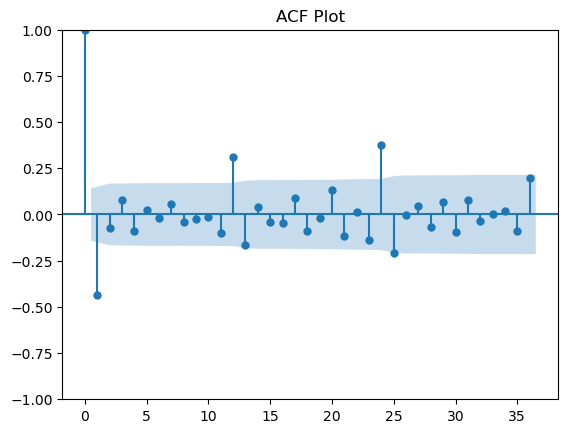

In [120]:
# ACF 플롯
plt.figure(figsize=(12, 6))
plot_acf(log_differenced, lags=36)
plt.title('ACF Plot')
plt.show()

In [150]:

acf_values = acf(differenced, nlags=40)
lags = np.arange(len(acf_values))

# 급격한 변화 시점 출력
for i in range(1, len(acf_values)):
    if abs(acf_values[i]) > 0.5:  # 예를 들어, 자기 상관 값이 0.5를 초과하는 경우
        print(f"Lag {i}: ACF = {acf_values[i]}")

<Figure size 1200x600 with 0 Axes>

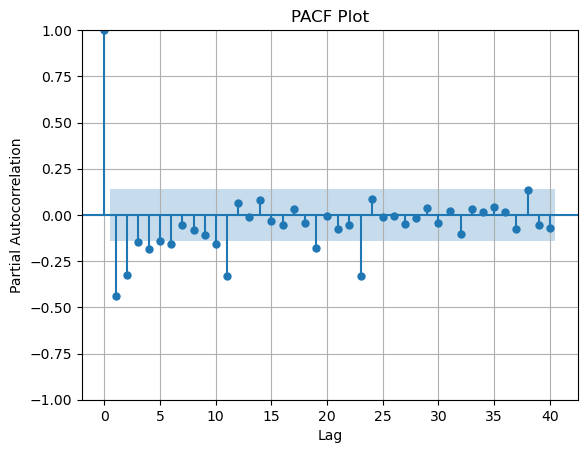

In [122]:
# PACF 플롯
plt.figure(figsize=(12, 6))
plot_pacf(log_differenced, lags=40)
plt.title('PACF Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [124]:
# log변환 할 필요가 없다. 괜히 결과만 헷갈리게 나온다.

In [267]:
differenced

1      -191.57650
2     -1193.52388
3      -296.13556
4      -953.95964
5      -208.49703
          ...    
187    1306.33520
188    1612.74925
189   -1180.31308
190    -587.96897
191    -660.16502
Name: 1, Length: 191, dtype: float64

In [271]:
train = differenced[:157]
test = differenced[158:191]

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodel

Best AIC: 2469.336311156394
Best Parameters: p=0, d=1, q=1


C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


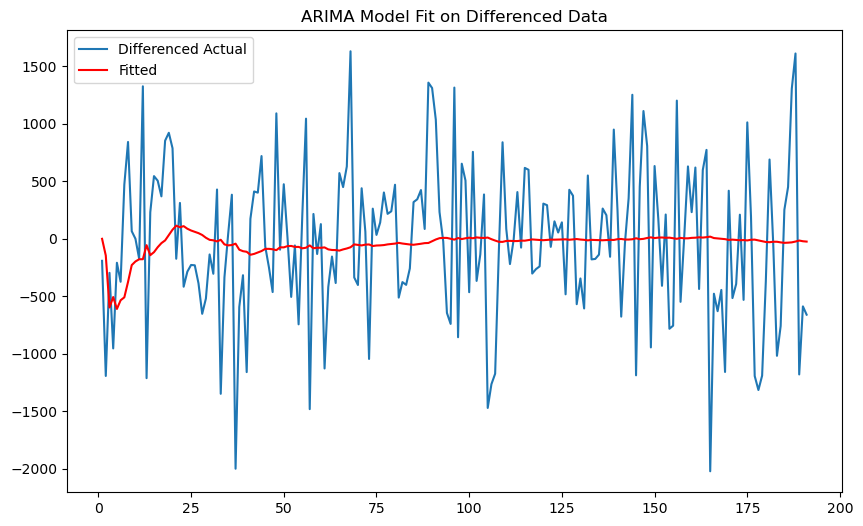

In [277]:
# 그리드 서치를 위한 파라미터 범위 정의
p_values = [0, 1, 2]
d_values = [1]  # 차분은 이미 수행됨
q_values = [0, 1, 2]

# 그리드 서치를 위한 파라미터 조합 생성
best_aic = np.inf
best_params = None
results = []

for p, d, q in product(p_values, d_values, q_values):
    try:
        # ARIMA 모델 적합
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # AIC 값 계산
        aic = model_fit.aic
        results.append((p, d, q, aic))
        
        # AIC 값을 통해 최적 파라미터 찾기
        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q)
    
    except Exception as e:
        print(f"Error with parameters (p={p}, d={d}, q={q}): {e}")

# 결과 출력
if best_params is not None:
    print(f"Best AIC: {best_aic}")
    print(f"Best Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}")
    
    # 최적 모델 적합 및 예측
    best_model = ARIMA(differenced, order=best_params)
    best_model_fit = best_model.fit()
    
    # 예측 시각화 (선택 사항)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(differenced, label='Differenced Actual')
    plt.plot(best_model_fit.fittedvalues, label='Fitted', color='red')
    plt.legend()
    plt.title('ARIMA Model Fit on Differenced Data')
    plt.show()
else:
    print("No valid model found.")



In [170]:
# 따라서 p = 1, d= 1 , q = 1인 것이 가장 최적의 파라미터이다. ARIMA(1,1,1) 최종 선택

In [279]:
# 더미변수 생성
# 코로나19
years_of_interest = [2020, 2021, 2022]
cow_df['covid_dummy'] = cow_df['year'].apply(lambda x: 1 if x in years_of_interest else 0)

In [281]:
# 더미변수 생성
# 구제역
years_of_interest = [2010,2011]
cow_df['Disease_dummy'] = cow_df['year'].apply(lambda x: 1 if x in years_of_interest else 0)

In [283]:
# 더미변수 생성
# 청탁 금지법
cow_df['Date'] = pd.to_datetime(cow_df["Date"])
cow_df['SD_dummy'] = (cow_df['Date'] >= '2016-09-01').astype(int)

In [285]:
# 더미변수 생성
# 명절 1,2,9,10월은 1로 처리 나머지는 0
months_of_interest = [1,2,9,10]
cow_df['hol_dummy'] = cow_df['Month'].apply(lambda x: 1 if x in months_of_interest else 0)

In [287]:
# 더미변수 생성 
# 한우 사육 구조 변화 
cow_df['SC_dummy'] = (cow_df['Date'] >= '2012').astype(int)

In [195]:
cow_df

,년-월,1++,1+,1,2,Date,Month,Month_Name,year,covid_dummy,Disease_dummy,SD_dummy,hol_dummy,SC_dummy
0,08-Jan,22901.14757,20577.05859,19004.17757,17435.07147,2008-01-01,1,Jan,2008,0,0,0,1,0
1,08-Feb,23208.93558,20908.60087,18812.60107,16692.78309,2008-02-01,2,Feb,2008,0,0,0,1,0
2,08-Mar,22159.84599,19619.94659,17619.07719,15669.12998,2008-03-01,3,Mar,2008,0,0,0,0,0
3,08-Apr,22091.84556,19619.08056,17322.94163,14571.03332,2008-04-01,4,Apr,2008,0,0,0,0,0
4,08-May,21445.54698,18658.58140,16368.98199,13765.77239,2008-05-01,5,May,2008,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,23-Aug,19293.72996,16293.19558,14563.59102,11066.08479,2023-08-01,8,Aug,2023,0,0,1,0,1
188,23-Sep,20191.40452,17733.27426,16176.34027,12554.71865,2023-09-01,9,Sep,2023,0,0,1,1,1
189,23-Oct,18873.48813,16240.84047,14996.02719,11778.05244,2023-10-01,10,Oct,2023,0,0,1,1,1
190,23-Nov,18333.33333,15741.92403,14408.05822,12230.20944,2023-11-01,11,Nov,2023,0,0,1,0,1


In [197]:
# 더미변수 정리
exog = cow_df[['Disease_dummy','hol_dummy','covid_dummy','SD_dummy','SC_dummy']]

model = ARIMA(cow_df['1'], exog = exog, order = (1,1,1))
results = model.fit()

C:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [199]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      1   No. Observations:                  192
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1504.811
Date:                Thu, 08 Aug 2024   AIC                           3025.622
Time:                        15:35:59   BIC                           3051.640
Sample:                             0   HQIC                          3036.161
                                - 192                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Disease_dummy  -639.7251   2.44e+04     -0.026      0.979   -4.84e+04    4.71e+04
hol_dummy       354.0619    102.438      3.456      0.001     153.287     554.837
covid_dummy     810.6416   2220.315     

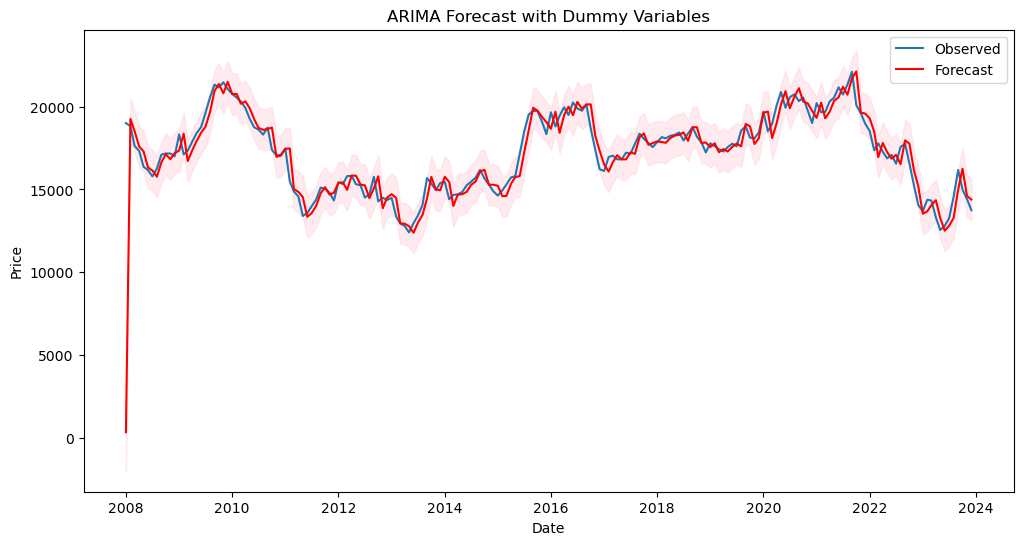

In [201]:
# 예측
pred = results.get_prediction(start=0, end=len(cow_df)-1, exog=exog)
pred_ci = pred.conf_int()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(cow_df['Date'], cow_df['1'], label='Observed')
plt.plot(cow_df['Date'], pred.predicted_mean, label='Forecast', color='r')
plt.fill_between(cow_df['Date'], pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast with Dummy Variables')
plt.legend()
plt.show()

In [307]:
# 그리드 서치를 위한 파라미터 범위 정의
p_values = [0, 1, 2]
d_values = [1]  # 차분은 이미 수행됨
q_values = [0, 1, 2]
exog = cow_df[['Disease_dummy','hol_dummy','covid_dummy','SD_dummy','SC_dummy']].iloc[1:158]

# 그리드 서치를 위한 파라미터 조합 생성
best_aic = np.inf
best_params = None
results = []

for p, d, q in product(p_values, d_values, q_values):
    try:
        # ARIMA 모델 적합
        model = ARIMA(train, exog = exog, order=(p, d, q))
        model_fit = model.fit()
        
        # AIC 값 계산
        aic = model_fit.aic
        results.append((p, d, q, aic))
        
        # AIC 값을 통해 최적 파라미터 찾기
        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q)
    
    except Exception as e:
        print(f"Error with parameters (p={p}, d={d}, q={q}): {e}")

# 결과 출력
if best_params is not None:
    print(f"Best AIC: {best_aic}")
    print(f"Best Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}")
    
    # 최적 모델 적합 및 예측
    best_model = ARIMA(differenced, exog = exog, order=best_params)
    best_model_fit = best_model.fit()
    
    # 예측 시각화 (선택 사항)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(differenced, label='Differenced Actual')
    plt.plot(best_model_fit.fittedvalues, label='Fitted', color='red')
    plt.legend()
    plt.title('ARIMA Model Fit on Differenced Data')
    plt.show()
else:
    print("No valid model found.")



C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best AIC: 2490.122621494429
Best Parameters: p=0, d=1, q=1


ValueError: The indices for endog and exog are not aligned

In [126]:
# 더미변수 추가해서 ARIMAX 했더니 0,1,1로 바뀜.

In [315]:
# 더미변수 정리
exog = cow_df[['Disease_dummy','hol_dummy','covid_dummy','SD_dummy','SC_dummy']].iloc[1:158]

model = ARIMA(train, exog = exog, order = (0,1,1))
results = model.fit()

C:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [317]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      1   No. Observations:                  157
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1238.061
Date:                Thu, 08 Aug 2024   AIC                           2490.123
Time:                        16:21:27   BIC                           2511.472
Sample:                             0   HQIC                          2498.794
                                - 157                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Disease_dummy   446.7133    315.796      1.415      0.157    -172.236    1065.662
hol_dummy        18.9582    103.070      0.184      0.854    -183.055     220.971
covid_dummy     364.6556    245.931     

In [331]:
# 예측
pred = results.get_prediction(start=0, end=len(cow_df)-1, exog=exog)
pred_ci = pred.conf_int()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(cow_df['Date'].iloc[1:158], train, label='Observed')
plt.plot(cow_df['Date'].iloc[1:158], pred.predicted_mean, label='Forecast', color='r')
plt.fill_between(cow_df['Date'], pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast with Dummy Variables')
plt.legend()
plt.show()

ValueError: Provided exogenous values are not of the appropriate shape. Required (35, 5), got (157, 5).

In [255]:
mae = mean_absolute_error(differenced, pred)
rmse = np.sqrt(mean_squared_error(differenced, pred))
mape = np.mean(np.abs((differenced - pred) / differenced)) * 100

InvalidParameterError: The 'y_pred' parameter of mean_absolute_error must be an array-like. Got <statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper object at 0x000001B14D9FDBE0> instead.

SyntaxError: invalid syntax (1532390229.py, line 1)